In [18]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [20]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

MildDemented_train = np.array(Dataset_loader('C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\train\\MildDemented',224)) 
ModerateDemented_train = np.array(Dataset_loader('C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\train\\ModerateDemented',224))
NonDemented_train=np.array(Dataset_loader('C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\train\\NonDemented',224))
VeryMildDemented_train=np.array(Dataset_loader('C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\train\\VeryMildDemented',224))



MildDemented_test = np.array(Dataset_loader('C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\test\\MildDemented',224))   
ModerateDemented_test = np.array(Dataset_loader('C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\test\\ModerateDemented',224))
NonDemented_test = np.array(Dataset_loader('C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\test\\NonDemented',224))
VeryMildDemented_test = np.array(Dataset_loader('C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\test\\VeryMildDemented',224))


100%|██████████| 12/12 [00:00<00:00, 363.57it/s]


# Create Label

In [21]:

MildDemented_train_label = np.zeros(len(MildDemented_train))
ModerateDemented_train_label = np.ones(len(ModerateDemented_train))
NonDemented_train_label = np.zeros(len(NonDemented_train))
VeryMildDemented_train_label = np.ones(len(VeryMildDemented_train))

MildDemented_test_label = np.zeros(len(MildDemented_test))
ModerateDemented_test_label = np.ones(len(ModerateDemented_test))
NonDemented_test_label = np.zeros(len(NonDemented_test))
VeryMildDemented_test_label = np.ones(len(VeryMildDemented_test))

# Merge data 
X_train = np.concatenate((MildDemented_train, ModerateDemented_train,NonDemented_train,VeryMildDemented_train), axis = 0)
Y_train = np.concatenate((MildDemented_train_label, ModerateDemented_train_label,NonDemented_train_label,VeryMildDemented_train_label), axis = 0)
X_test = np.concatenate((MildDemented_test, ModerateDemented_test,NonDemented_test, VeryMildDemented_test), axis = 0)
Y_test = np.concatenate((MildDemented_test_label,ModerateDemented_test_label,NonDemented_test_label,VeryMildDemented_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 4)
Y_test = to_categorical(Y_test, num_classes= 4)

# Train and Evalutation split

In [22]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

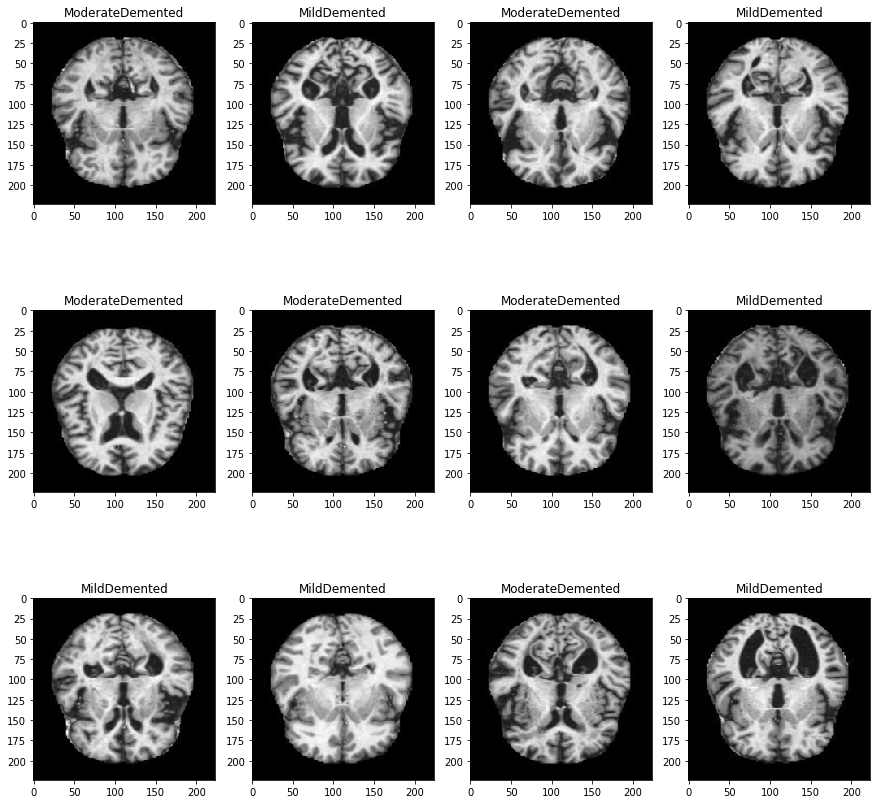

In [23]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('MildDemented')
    elif np.argmax(Y_train[i]) == 1:
        ax.title.set_text('ModerateDemented')
             
    elif np.argmax(Y_train[i]) == 0:
        ax.title.set_text('NonDemented')
        
    elif np.argmax(Y_train[i]) == 0:
        ax.title.set_text('VeryMildDemented')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [25]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Vgg 16 ----->

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Activation, Dropout
from keras.models import Model
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.models import Sequential
import keras  
from keras.applications.vgg16 import VGG16
#from  keras.applications import VGG16, ResNet50
from keras import backend as K
from keras import optimizers
import os
import numpy as np
import errno
from matplotlib import pyplot as plt
import time

In [27]:
# test >> yes = 62 | no - 34
# training >> yes =  145 | no - 81

# NN Parameters
image_size = 224     
train_batchsize = 10  
epochs = 90

In [28]:
# Image Dataset Directory
train_dir = 'C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\train' #'dataset/train'

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [29]:
# Train datagenerator
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )


In [30]:
def vgg16_finetuned():

  vgg_conv = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(image_size, image_size, 3))

  for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

  model = Sequential()
  model.add(vgg_conv)
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4, activation= 'sigmoid'))

  return model

In [33]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 90:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 60:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [35]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = vgg16_finetuned()
model.summary()

    8192/58889256 [..............................] - ETA: 0s

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [20]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="C:\\Users\\Sandeep Shenoy S\\Desktop\\ALZHEIMERS\\vgg.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\Paramanand\.conda\envs\brain_tumor\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
33/33 [==============================] - 9210s 274s/step - loss: 0.6686 - accuracy: 0.6623 - val_loss: 0.3291 - val_accuracy: 0.9104 - lr: 1.0000e-04
Epoch 2/15


**PREDICTION**


In [0]:
model.load_weights("/content/drive/My Drive/alzeim/vgg.weights.best.hdf5")

In [0]:
Y_val_pred = model.predict(x_val)

In [60]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

1.0

In [0]:
Y_pred = model.predict(X_test)

In [62]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


**TESTING**

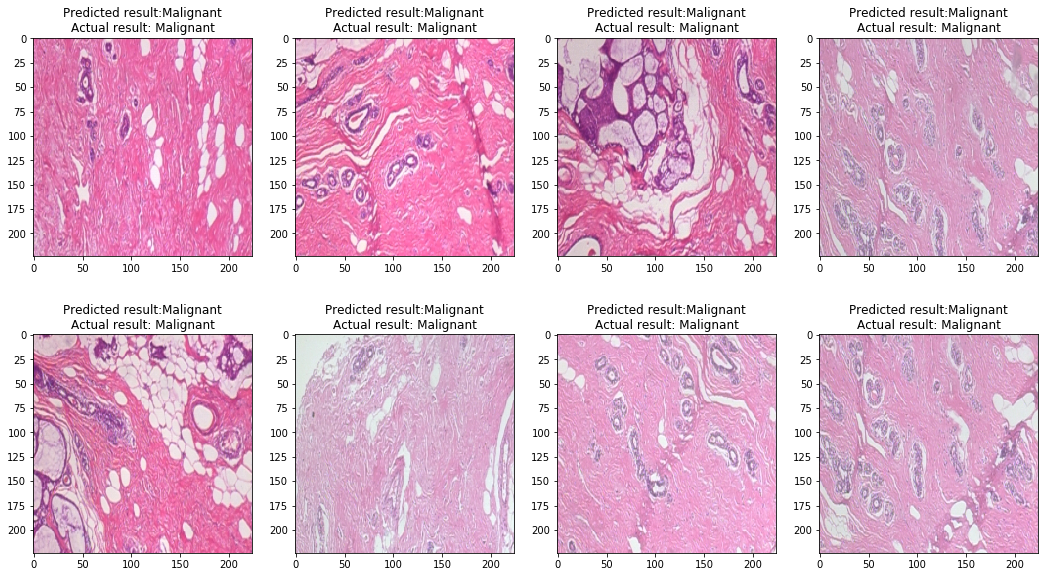

In [64]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "MildDemented"
    elif:
        return "ModerateDemented"
    elif:
        return "NonDemented"
    elif:
        return "VeryMildDemented"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()